In [12]:
# !git clone https://github.com/time-series-foundation-models/lag-llama/
# !pip3 install -r requirements.txt --quiet
# !huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir lag-llama

In [1]:
cd lag-llama

/Users/alvarocorralescano/Documents/GitHub/wave-height-prediction/lag-llama


In [3]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

We create a function for Lag-Llama inference that we can reuse. This function returns the predictions for the given prediction horizon. The forecast will be of shape (num_samples, prediction_length), where `num_samples` is the number of samples sampled from the predicted probability distribution for each timestep.

In [4]:
    def get_lag_llama_predictions(dataset, prediction_length, context_length=32, num_samples=20, device="cpu", batch_size=64, nonnegative_pred_samples=True):
        ckpt = torch.load("lag-llama/lag-llama.ckpt", map_location=torch.device(device))
        estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

        estimator = LagLlamaEstimator(
            # ckpt_path="lag-llama.ckpt",
            ckpt_path = 'lag-llama/lag-llama.ckpt',
            prediction_length=prediction_length,
            context_length=context_length,
            device =

            # estimator args
            input_size=estimator_args["input_size"],
            n_layer=estimator_args["n_layer"],
            n_embd_per_head=estimator_args["n_embd_per_head"],
            n_head=estimator_args["n_head"],
            scaling=estimator_args["scaling"],
            time_feat=estimator_args["time_feat"],

            nonnegative_pred_samples=nonnegative_pred_samples,

            # linear positional encoding scaling
            rope_scaling={
                "type": "linear",
                "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
            },

            batch_size=batch_size,
            num_parallel_samples=num_samples,
        )

        lightning_module = estimator.create_lightning_module().to(device)
        transformation = estimator.create_transformation()
        predictor = estimator.create_predictor(transformation, lightning_module)

        forecast_it, ts_it = make_evaluation_predictions(
            dataset=dataset,
            predictor=predictor,
            num_samples=num_samples
        )
        forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))
        tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))

        return forecasts, tss

In [5]:
dataset = get_dataset("m4_weekly")

In [6]:
prediction_length = dataset.metadata.prediction_length
context_length = prediction_length*3
num_samples = 20
device = torch.device('cpu')

In [7]:
forecasts, tss = get_lag_llama_predictions(
    dataset.test,
    prediction_length=prediction_length,
    num_samples=num_samples,
    context_length=context_length,
    device=device
)

Forecasting batches:   0%|          | 0/359 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/359 [00:00<?, ?it/s]

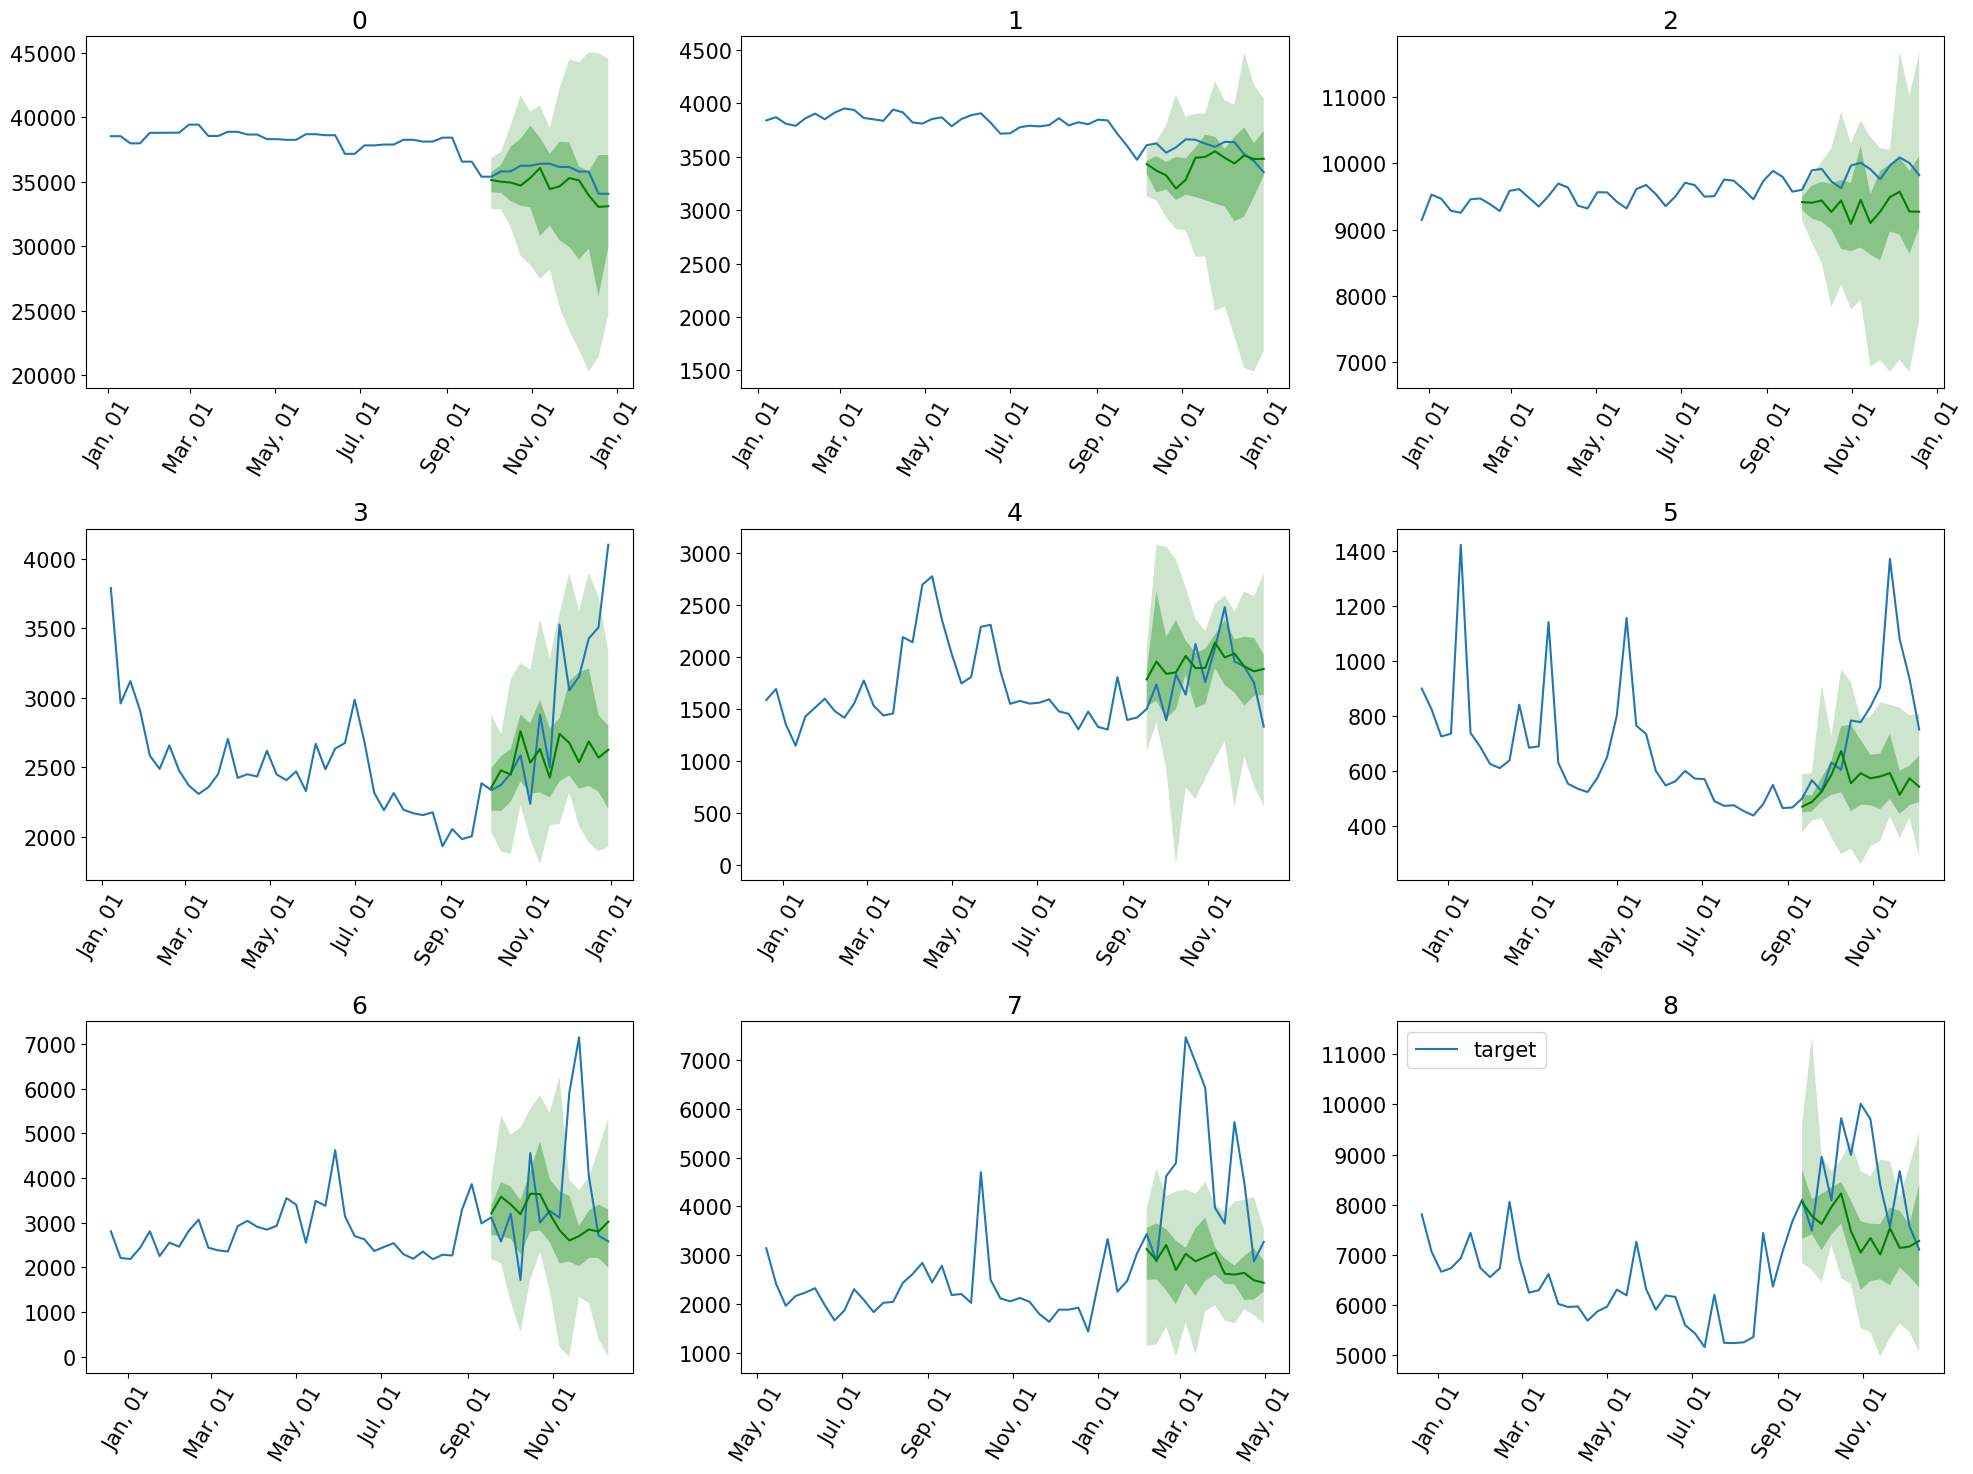

In [8]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

## Fine-tuning

Let us fine-tune the Lag-Llama base model with a few data-specific changes. Feel Free to change the hyperparameters below:

In [11]:
ckpt = torch.load("lag-llama/lag-llama.ckpt", map_location=device)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
        ckpt_path="lag-llama/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,
        device = device,

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=5e-4,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        # rope_scaling={
        #     "type": "linear",
        #     "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        # },

        batch_size=64,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 50,}, # <- lightning trainer arguments
    )

In [12]:
predictor = estimator.train(dataset.train, cache_data=True, shuffle_buffer_length=1000)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
Missing logger folder: /Users/alvarocorralescano/Documents/GitHub/wave-height-prediction/lag-llama/lightning_logs

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 8.25937 (best 8.25937), saving model to '/Users/alvarocorralescano/Documents/GitHub/wave-height-prediction/lag-llama/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.89551 (best 6.89551), saving model to '/Users/alvarocorralescano/Documents/GitHub/wave-height-prediction/lag-llama/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.80655 (best 6.80655), saving model to '/Users/alvarocorralescano/Documents/GitHub/wave-height-prediction/lag-llama/lightning_logs/version_0/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.71481 (best 6.71481), saving model to '/Users/alvarocorralescano/Documents/GitHub/wave-height-prediction/lag-llama/lightning_logs/version_0/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.68865 (best 6.68865),

In [13]:
forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset.test,
        predictor=predictor,
        num_samples=num_samples
    )

forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))
tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))

Forecasting batches:   0%|          | 0/3 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/3 [00:00<?, ?it/s]

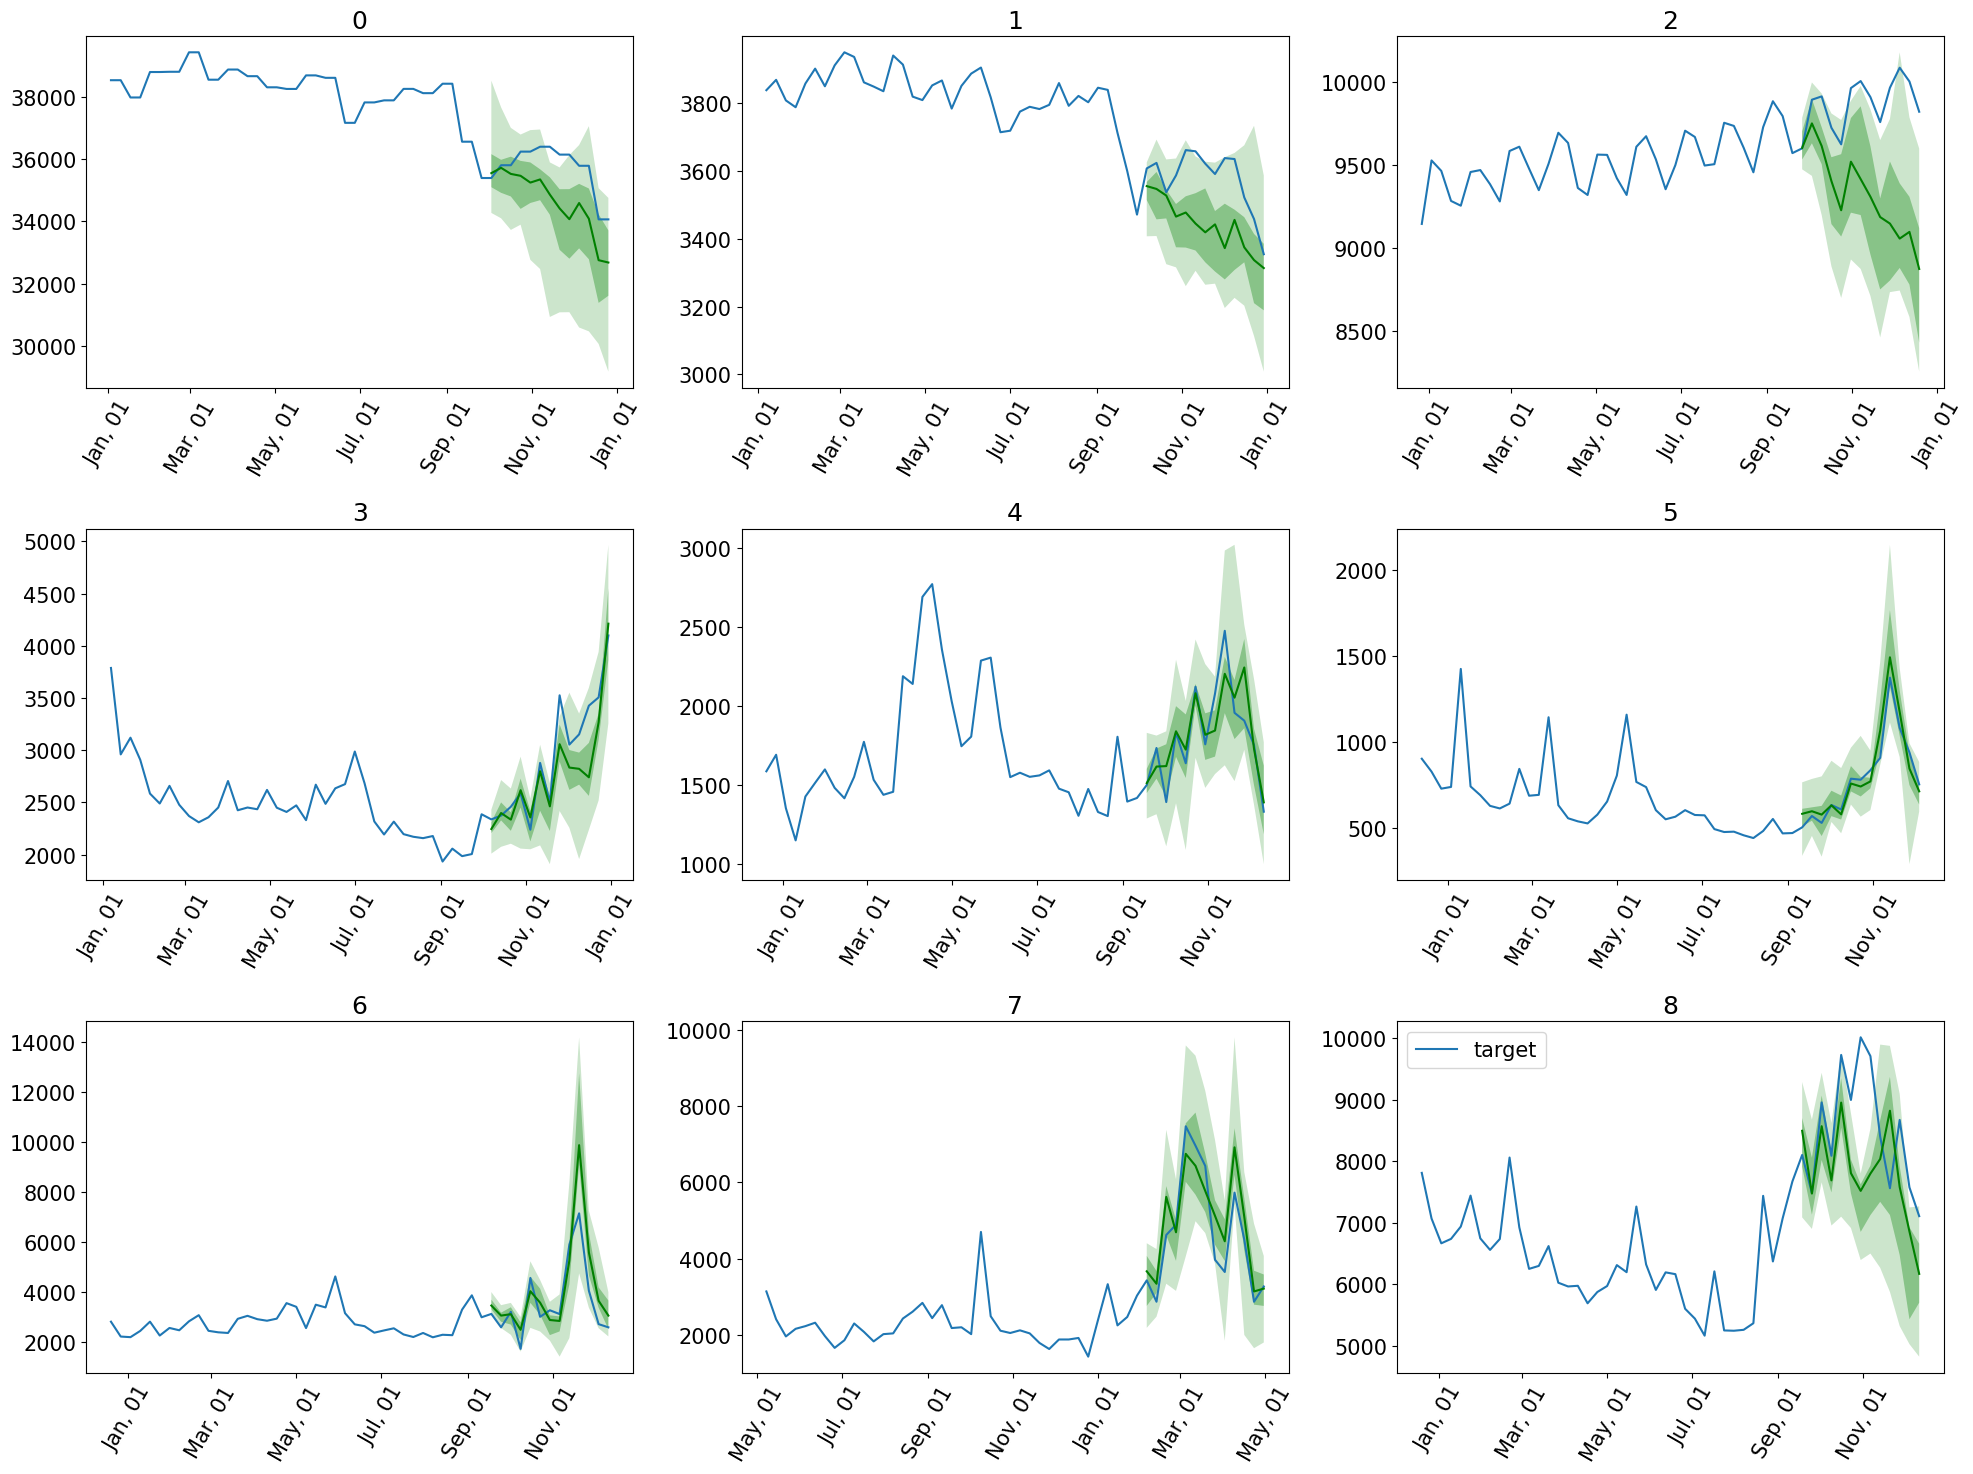

In [14]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [40]:
for idx, (forecast, ts) in enumerate(zip(forecasts, tss)):
    print(forecast)



gluonts.model.forecast.SampleForecast(info=None, item_id='0', samples=array([[34582.348, 33858.094, 34144.004, 33896.094, 34694.992, 34683.832,
        34215.332, 34333.645, 33322.74 , 33089.01 , 32660.91 , 31478.594,
        32056.566],
       [34800.766, 34996.26 , 35529.332, 34404.758, 34409.965, 34197.977,
        34269.13 , 34403.14 , 33719.42 , 33512.695, 32784.93 , 31281.812,
        31610.307],
       [34274.29 , 34101.668, 33727.883, 34033.113, 34085.668, 33885.31 ,
        33488.707, 32676.67 , 31628.754, 30589.178, 30465.084, 30514.615,
        30339.377],
       [34948.89 , 34770.285, 35431.63 , 36177.004, 36480.54 , 35523.727,
        33250.484, 32585.268, 32476.564, 34592.684, 34182.14 , 32754.36 ,
        31976.434],
       [33982.91 , 34244.44 , 33451.44 , 33239.16 , 32259.525, 31152.395,
        30337.965, 31009.658, 30004.508, 30628.14 , 30811.95 , 30061.81 ,
        29169.506],
       [35548.39 , 35108.047, 35053.637, 34391.223, 34593.98 , 35459.254,
        35048.82

In [51]:
help(forecasts[0])

Help on SampleForecast in module gluonts.model.forecast object:

class SampleForecast(Forecast)
 |  SampleForecast(samples: numpy.ndarray, start_date: pandas._libs.tslibs.period.Period, item_id: Optional[str] = None, info: Optional[Dict] = None) -> None
 |  
 |  A `Forecast` object, where the predicted distribution is represented
 |  internally as samples.
 |  
 |  Parameters
 |  ----------
 |  samples
 |      Array of size (num_samples, prediction_length) (1D case) or
 |      (num_samples, prediction_length, target_dim) (multivariate case)
 |  start_date
 |      Start of the forecast.
 |  item_id
 |      Identifier of the item being forecasted.
 |  info
 |      Additional information that the forecaster may provide e.g. estimated
 |      parameters, number of iterations ran etc.
 |  
 |  Method resolution order:
 |      SampleForecast
 |      Forecast
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getnewargs_ex__ = validated_getnewargs_ex(self) from gluonts.core.com

In [63]:
forecasts[0].mean

array([35772.14 , 35651.07 , 35388.258, 35328.547, 35104.727, 35004.977,
       34460.324, 34095.758, 33876.99 , 33990.02 , 33728.133, 32602.178,
       32333.557], dtype=float32)

In [64]:
forecasts[0].samples

array([[34582.348, 33858.094, 34144.004, 33896.094, 34694.992, 34683.832,
        34215.332, 34333.645, 33322.74 , 33089.01 , 32660.91 , 31478.594,
        32056.566],
       [34800.766, 34996.26 , 35529.332, 34404.758, 34409.965, 34197.977,
        34269.13 , 34403.14 , 33719.42 , 33512.695, 32784.93 , 31281.812,
        31610.307],
       [34274.29 , 34101.668, 33727.883, 34033.113, 34085.668, 33885.31 ,
        33488.707, 32676.67 , 31628.754, 30589.178, 30465.084, 30514.615,
        30339.377],
       [34948.89 , 34770.285, 35431.63 , 36177.004, 36480.54 , 35523.727,
        33250.484, 32585.268, 32476.564, 34592.684, 34182.14 , 32754.36 ,
        31976.434],
       [33982.91 , 34244.44 , 33451.44 , 33239.16 , 32259.525, 31152.395,
        30337.965, 31009.658, 30004.508, 30628.14 , 30811.95 , 30061.81 ,
        29169.506],
       [35548.39 , 35108.047, 35053.637, 34391.223, 34593.98 , 35459.254,
        35048.82 , 34420.082, 33817.277, 33612.113, 34088.32 , 31812.625,
        3399

In [65]:
len(forecasts)

359